In [24]:
import os

import omrmodules
import torch
import cv2 as cv
import importlib

import numpy as np
from omrmodules.datasets.MuscimaMeasures import visualize_bboxes
from omrmodules.semantics.SystemObjects import SongFactory

from torchvision.utils import draw_bounding_boxes
from PIL import Image

def visualize(image, boxes):
    viz_image = (image*255).type(torch.ByteTensor)
    viz_boxes = omrmodules.semantics.SystemObjects.denormalize_bboxes(np.asarray(boxes), viz_image)
    viz_boxes = torch.asarray(viz_boxes)

    viz_im_with_bounding_boxes = draw_bounding_boxes(viz_image, viz_boxes, width=5, colors="red")

    Image.fromarray(np.moveaxis(viz_im_with_bounding_boxes.numpy(), 0, -1))

In [5]:

###
# preparation
IMAGE = os.path.join('..', 'samples', 'one_handed.jpg')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# load models
MODEL_MEASURE = os.path.join('..', 'saved_models', 'muscima_measures.pt')
MODEL_OBJECT = os.path.join('..', 'saved_models', 'muscima_objects_pitchonly.pt')
model_measures = torch.load(MODEL_MEASURE, map_location=torch.device('cpu'))
model_objects = torch.load(MODEL_OBJECT, map_location=torch.device('cpu'))
model_measures.to(device)
model_objects.to(device)
model_measures.eval()
model_objects.eval()
model_measures([torch.rand(1,400,400).to(device)])
model_objects([torch.rand(1,400,400).to(device)])
    
###
#

# read image
image = cv.imread(IMAGE)

# pre-process image
image = omrmodules.normalization.preprocess.processnotesheet(image)

# model inference
image = (np.expand_dims(image, 0) / 255.0).astype(np.float32)
image = [torch.from_numpy(image).to(device)]
measure_dict = model_measures(image)
object_dict = model_objects(image)

# pass results to SongFactory



In [12]:
measure_dict[0]['labels']

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2],
       device='cuda:0')

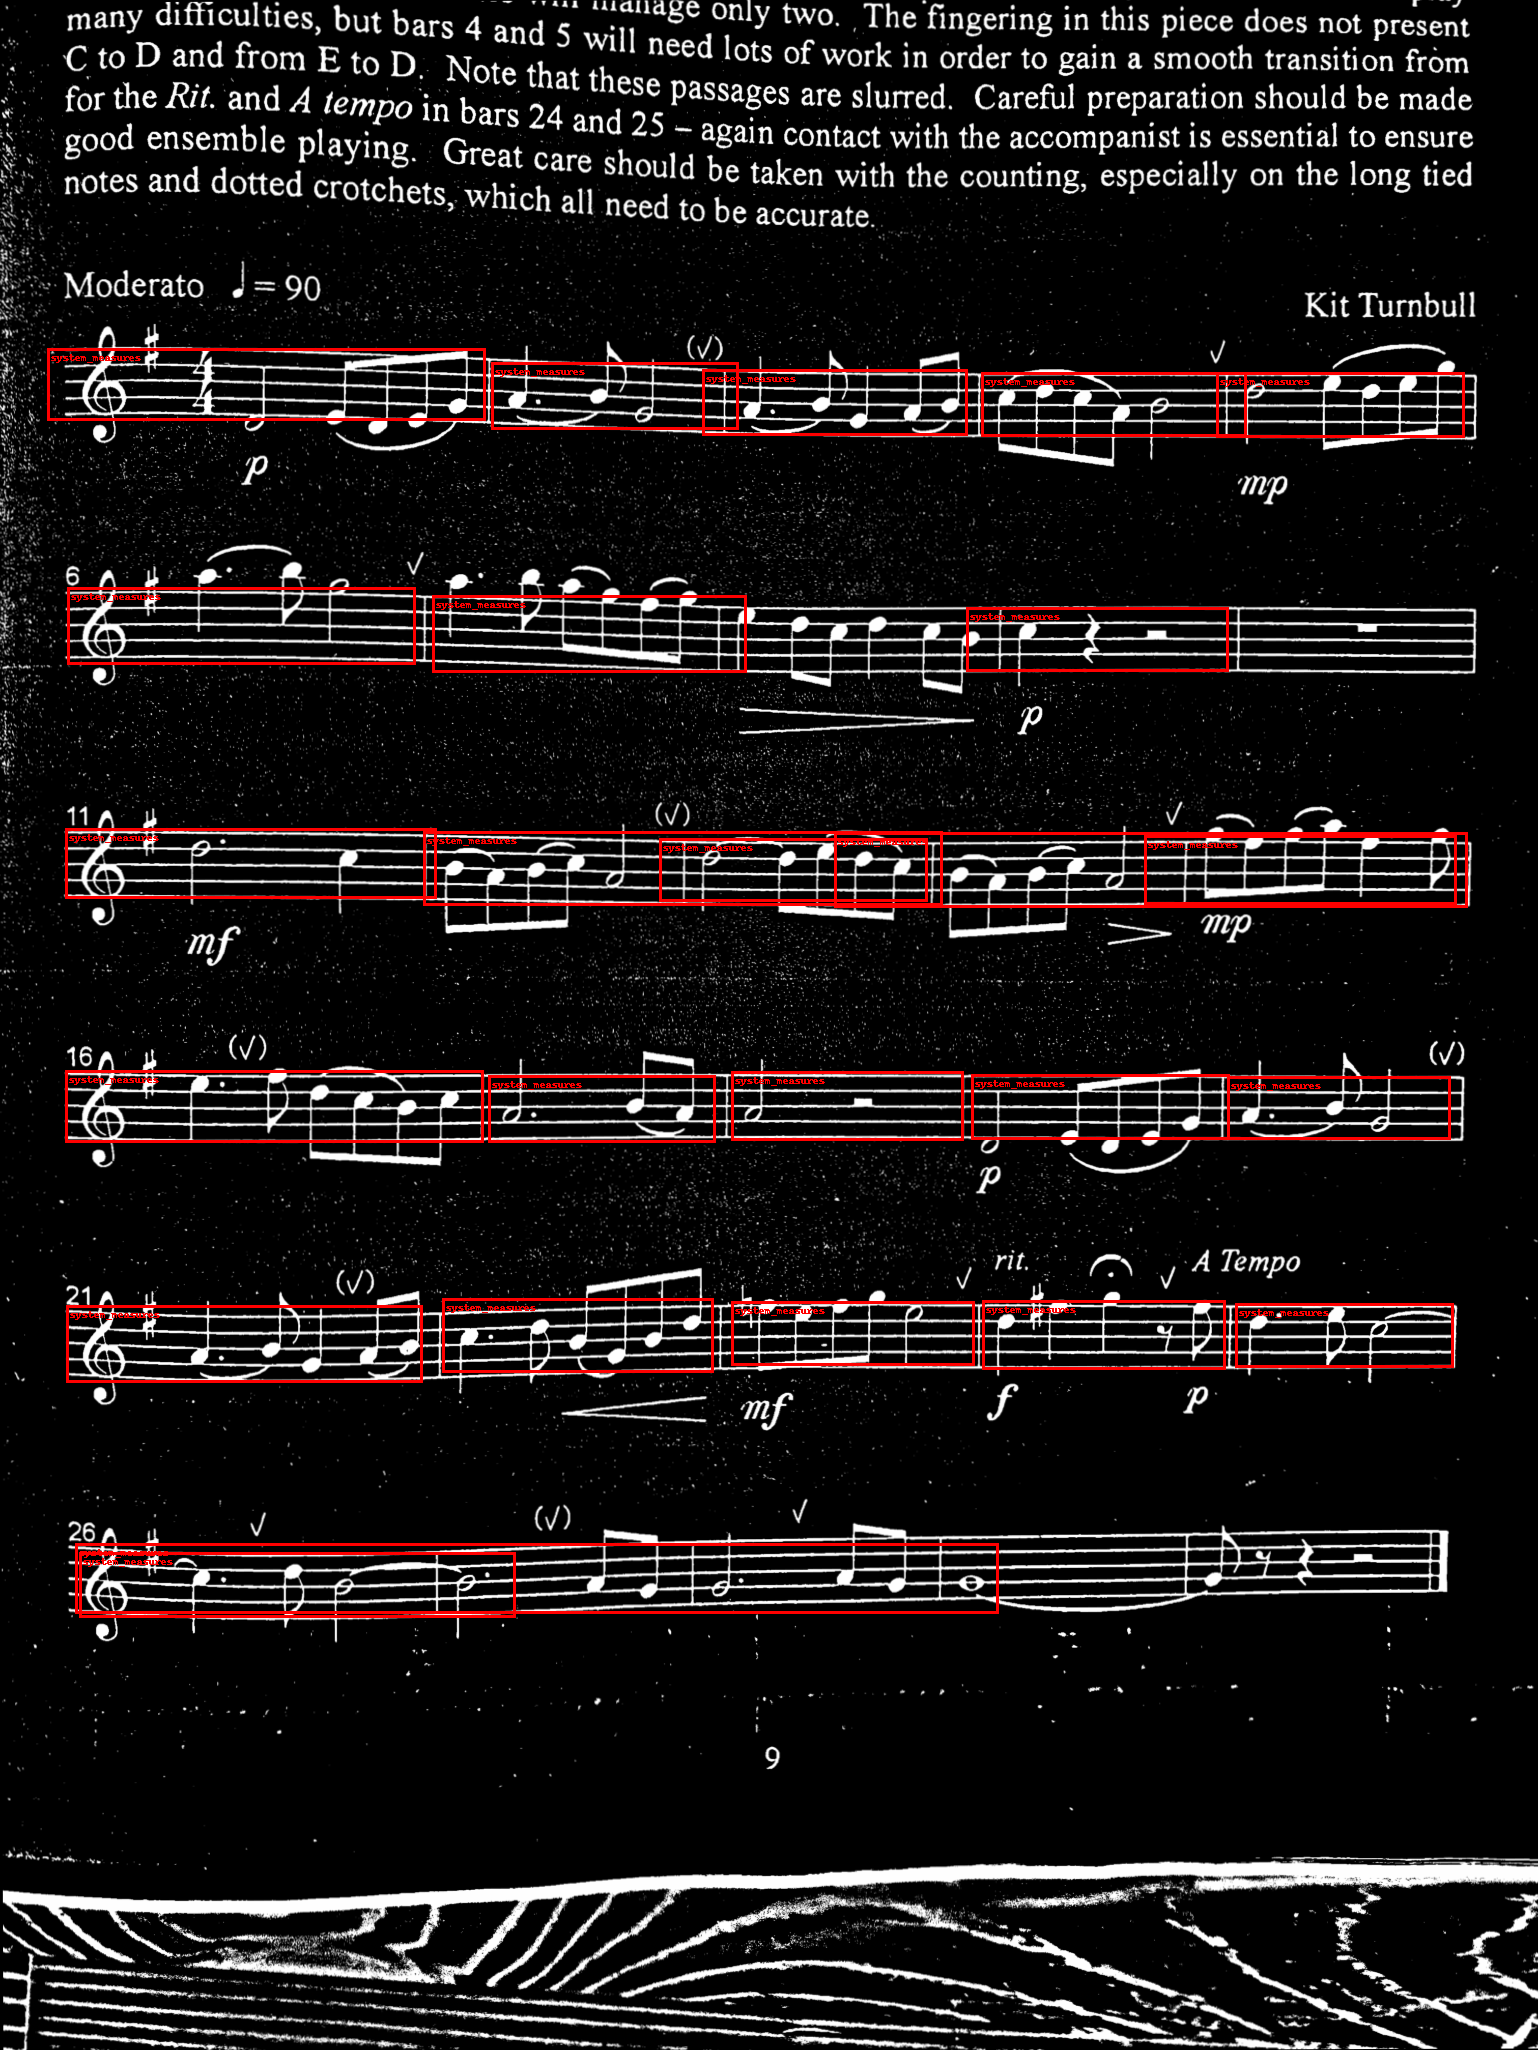

In [23]:
visualize_bboxes(image[0], measure_dict[0], threshold=0.5)

In [26]:
importlib.reload(omrmodules.semantics.SystemObjects)

<module 'omrmodules.semantics.SystemObjects' from 'c:\\repositories\\omrtorch\\omrmodules\\semantics\\SystemObjects.py'>

In [29]:
he_wi = image[0].shape[1:3]
system_measures, staff_measures = SongFactory.process_measure_dict(measure_dict[0], he_wi)

In [21]:
songFactory = omrmodules.semantics.SystemObjects.SongFactory(image[0], measure_dict[0], object_dict[0])

song = songFactory.song

In [38]:
np.var(system_measures[:,3]-system_measures[:,1])

5.1915745e-06

In [37]:
system_measures[:,3]-system_measures[:,1]

array([0.03157526, 0.03384405, 0.03724742, 0.03588063, 0.03107306,
       0.03526604, 0.03086567, 0.03209417, 0.03256619, 0.03206801,
       0.03214644, 0.03798532, 0.03651652, 0.03414619, 0.03132981,
       0.03048661, 0.0315375 , 0.03307481, 0.03574225], dtype=float32)

In [22]:
song.systems

In [26]:

boxes = []
for system in song.systems:
    boxes.append(system.bbox())
    
omrmodules.semantics.SystemObjects.denormalize_bboxes(np.asarray(boxes), image[0])

array([[   0.        ,    0.        , 1496.        ,  554.59313862],
       [   0.        ,  554.59313862, 1496.        ,  806.88263889],
       [   0.        ,  806.88263889, 1496.        , 1056.32858433],
       [   0.        , 1056.32858433, 1496.        , 1234.58254784],
       [   0.        , 1234.58254784, 1496.        , 1404.10848387],
       [   0.        , 1404.10848387, 1496.        , 1995.        ]])

In [27]:
system1 = song.systems[1]
system1.measures

In [28]:
boxes2 = []
for system in song.systems:
    for measure in system.measures:
        boxes2.append(measure.bbox())

In [19]:
from torchvision.utils import draw_bounding_boxes
from PIL import Image

def visualize(image, boxes):
    viz_image = (image*255).type(torch.ByteTensor)
    viz_boxes = omrmodules.semantics.SystemObjects.denormalize_bboxes(np.asarray(boxes), viz_image)
    viz_boxes = torch.asarray(viz_boxes)

    viz_im_with_bounding_boxes = draw_bounding_boxes(viz_image, viz_boxes, width=5, colors="red")

    Image.fromarray(np.moveaxis(viz_im_with_bounding_boxes.numpy(), 0, -1))

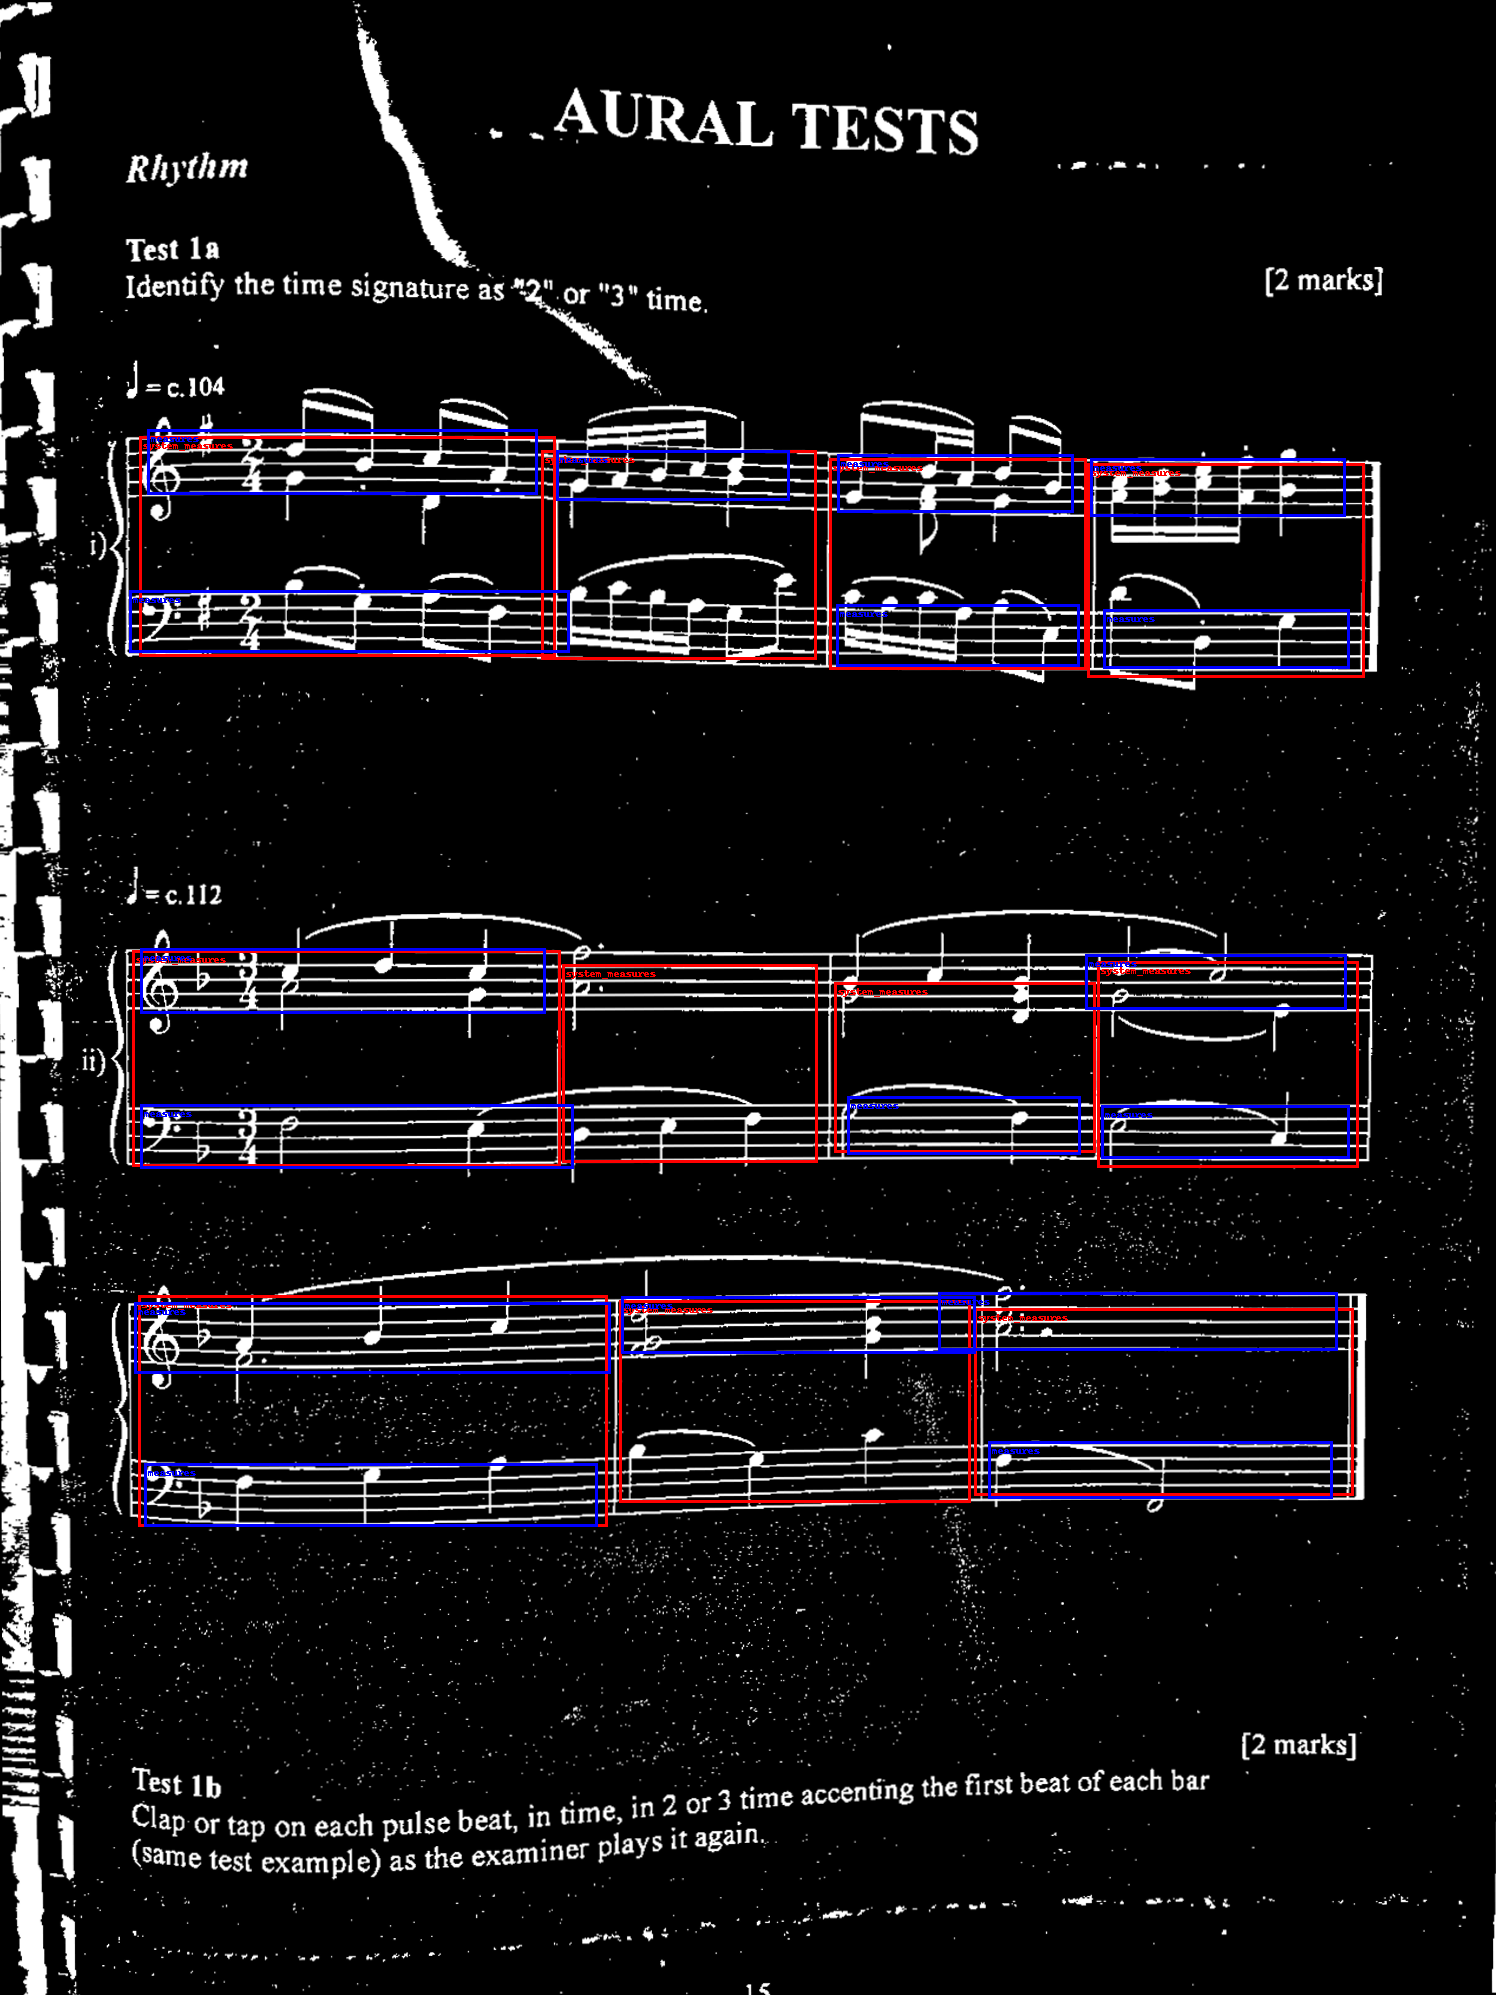

In [55]:
visualize_bboxes(image[0], measure_dict[0])

In [57]:
sbox = np.asarray(boxes2)
sort_order = np.argsort(sbox[:,1])
sbox = sbox[sort_order]

In [ ]:
# create a list of list of bboxes
groups = []
groups.append(np.expand_dims(sbox[0,:], axis=0))
top = np.average(groups[0][:,1])
bottom = np.average(groups[0][:,3])

In [ ]:
for box in sbox:
    center = (box[1] + box[3])/2
    if top < center < bottom:
        groups[0]([groups[0], np.expand_dims(box, 0)], axis=0)

    

ValueError: could not broadcast input array from shape (2,4) into shape (1,4)

In [ ]:
if top < center < bottom:
        groups[0] = np.vstack([groups[0], box])

In [ ]:
bottom

0.27799154818058014

In [58]:
staves = songFactory.staves

In [59]:
staves

In [60]:
grouped = [staff.measures for staff in staves]
ungrouped = np.vstack(grouped)
left_limit = np.min(ungrouped[:,0])
right_limit = np.max(ungrouped[:,2])
mingap = np.average(ungrouped[:,2] - ungrouped[:,0])/2


In [61]:
np.argsort(grouped[5][:,0])

array([0, 1], dtype=int64)

In [62]:
print(left_limit)
print(right_limit)

0.086606875
0.90205294


In [63]:
for gid, group in enumerate(grouped):
    top = np.average(group[:,1])
    bottom = np.average(group[:,3])
    for idx, measure in enumerate(group):
        if idx == 0: # check left of the first detection
            if measure[0] > left_limit + mingap:
                synth = [left_limit, top, measure[0], bottom]
                grouped[gid] = np.vstack([group, synth])
        if idx == len(group) - 1: # check right of the last detection
            if measure[2] < right_limit - mingap:
                synth = [measure[2], top, right_limit, bottom]
                grouped[gid] = np.vstack([group, synth])
        else:
            if group[idx+1][0] - measure[2] > 0:
                synth = [measure[2], top, group[idx+1], bottom]
                grouped[gid] = np.vstack([group, synth])
for idx in range(len(staves)):
    staves[idx].measures = grouped[idx]
    staves[idx].measures.sort()


                


In [77]:
songFactory.staves[4].measures

array([[0.09002691, 0.40799975, 0.65300494, 0.6885473 ],
       [0.40799975, 0.65300494, 0.6885473 , 0.90205294]], dtype=float32)

In [76]:
staves[4].measures

array([[0.09002691, 0.40799975, 0.65300494, 0.6885473 ],
       [0.40799975, 0.65300494, 0.6885473 , 0.90205294]], dtype=float32)

In [ ]:
groups = np.vstack((groups[0], groups[0]))

ValueError: could not broadcast input array from shape (2,4) into shape (4,)